# Exploring LinkedIn Postings Data

Goals:
- Load and inspect postings
- Clean salaries, titles, and timestamps
- Complete initial EDA (exploratory data analysis) and visualizations

# Imports and Setup

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Paths
DATA_DIR = Path('../data')
RAW_PATH = DATA_DIR / 'postings.csv'
ZIP_MAP_PATH = DATA_DIR / 'us_zip_code_mapping.csv'
CLEANED_PATH = DATA_DIR / 'postings_cleaned.csv'

# Initial data investigation

In [3]:
postings = pd.read_csv(RAW_PATH)
print('shape:', postings.shape)

shape: (123849, 31)


In [4]:
zip_state_map = pd.read_csv(ZIP_MAP_PATH)
postings = pd.merge(postings, zip_state_map, on='zip_code', how='left')
display(postings.head())

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,work_type,currency,compensation_type,normalized_salary,zip_code,fips,usps_default_state,state,usps_default_city,metro_area
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0,NJ,New Jersey,Princeton,"Trenton-Princeton, NJ"
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0,CO,Colorado,Fort Collins,"Fort Collins-Loveland, CO"
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0,OH,Ohio,Cincinnati,"Cincinnati, OH-KY-IN"
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0,NY,New York,New Hyde Park,"New York-Newark-Jersey City, NY-NJ"
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0,IA,Iowa,Burlington,"Burlington, IA-IL"


In [5]:
postings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [6]:
display(postings.isna().sum().sort_values().tail(25))

work_type                          0
description                        7
views                           1689
company_id                      1717
company_name                    1719
zip_code                       20872
usps_default_state             22525
state                          22525
usps_default_city              22525
metro_area                     26219
fips                           27415
formatted_experience_level     29409
application_url                36665
posting_domain                 39968
normalized_salary              87776
pay_period                     87776
compensation_type              87776
currency                       87776
min_salary                     94056
max_salary                     94056
applies                       100529
remote_allowed                108603
med_salary                    117569
skills_desc                   121410
closed_time                   122776
dtype: int64

In [7]:
for col in ['pay_period', 'work_type', 'formatted_work_type', 'application_type', 'formatted_experience_level','sponsored', 'compensation_type','currency']:
    print(f"{col}: {postings[col].unique()}")

pay_period: ['HOURLY' 'YEARLY' nan 'MONTHLY' 'WEEKLY' 'BIWEEKLY']
work_type: ['FULL_TIME' 'INTERNSHIP' 'CONTRACT' 'PART_TIME' 'TEMPORARY' 'VOLUNTEER'
 'OTHER']
formatted_work_type: ['Full-time' 'Internship' 'Contract' 'Part-time' 'Temporary' 'Volunteer'
 'Other']
application_type: ['ComplexOnsiteApply' 'SimpleOnsiteApply' 'OffsiteApply' 'UnknownApply']
formatted_experience_level: [nan 'Entry level' 'Mid-Senior level' 'Associate' 'Director' 'Internship'
 'Executive']
sponsored: [0]
compensation_type: ['BASE_SALARY' nan]
currency: ['USD' nan 'CAD' 'BBD' 'EUR' 'AUD' 'GBP']


## Understanding salary anomalies

In [8]:
postings['normalized_salary'].describe()
# min 0, max 535,600,000.0 -> is this right? these should be normalized to annual salary

count    3.607300e+04
mean     2.053270e+05
std      5.097627e+06
min      0.000000e+00
25%      5.200000e+04
50%      8.150000e+04
75%      1.250000e+05
max      5.356000e+08
Name: normalized_salary, dtype: float64

In [9]:
print(sum(postings['normalized_salary']==0)) # 14 jobs where salary = 0
print(sum((postings['normalized_salary']> 0) & (postings['normalized_salary']<100) )) # 317 where 0 < salary < 100
print(sum(postings['normalized_salary']>1000000)) # 38 where salary > 1M

14
317
38


In [10]:
def examine_posting(posting):
    posting.reset_index()
    print(posting['title'][0])
    print(posting['min_salary'][0], posting['normalized_salary'][0], posting['max_salary'][0])
    print(posting['pay_period'][0], posting['formatted_work_type'][0])
    print(posting['description'][0])
    print("----")

# check postings w/ extreme values
examine_posting(postings[postings['normalized_salary']==0].head(1).reset_index())
examine_posting(postings[postings['normalized_salary']<1000].head(1).reset_index())
examine_posting(postings[postings['normalized_salary']>1000000].head(1).reset_index())
examine_posting(postings[postings['normalized_salary']>5000000].head(1).reset_index())

Independent Sales Representative
nan 0.0 nan
YEARLY Contract
Location: Remote
Job Type: Commission-Based
About Us: Odin Disc Golf is an innovative newcomer to the sports apparel scene, dedicated to transforming the disc golf experience. Our flagship product, the Original ODIN Disc Golf Jacket, blends cutting-edge design with premium materials to elevate performance and style on the course.
Job Description: We're seeking motivated Independent Sales Representatives to leverage their sales expertise in generating sales for the Original ODIN Disc Golf Jacket. As a key member of our team, you'll play a pivotal role in introducing our brand to the market and driving revenue growth.
Responsibilities:Use your sales experience to generate sales for the Original ODIN Disc Golf Jacket.
Requirements:Previous sales experience, preferably within the sports apparel or outdoor recreation industry.Genuine passion for disc golf and understanding of its community and culture.Strong communication and inte

Observations:
* it is possible for a 0 salary, if it's unpaid or sales-based (so guaranteed salary is 0)
* sometimes HOURLY/YEARLY is inaccurate
* if normalized salary >0 but <1000, salary should likely be 100x (e.g. it says 200 but should be 200,000)
* sometimes min/max salary seems correct but the normalized salary is just incorrect, and should be fixed
  * e.g. min 240000.0, max 275000.0, but normalized is 535600000.0 

# Clean data

## Remove duplicate postings

Remove exact duplicate descriptions (likely duplicates from original ingestion/scraping).

In [11]:
before = len(postings)
postings.drop_duplicates(subset=['description'], inplace=True)
after = len(postings)
print(f"Dropped {before - after} duplicate rows. Updated row count: {after} (from {before} originally)")

Dropped 16021 duplicate rows. Updated row count: 107828 (from 123849 originally)


## Fix Salaries

Rationale:
- Some salaries appear hourly (small numbers), some appear scaled incorrectly (e.g. 200 → likely 200k), and some normalized values are wrong.
- Need to compute a `corrected_salary` using a combination of `min_salary`, `max_salary`, and `normalized_salary` based on assumed heuristics

In [12]:
def compute_corrected_salaries(df):
    # start with existing normalized salary
    corrected_salaries = df['normalized_salary'].copy()

    # treat differently for different pay periods
    hourly_pay_period = df['pay_period'] == 'HOURLY'
    monthly_pay_period = df['pay_period'] == 'MONTHLY'
    yearly_pay_period = df['pay_period'] == 'YEARLY'

    # if min/max exist -> use their average
    has_minmax = df['min_salary'].notna() & df['max_salary'].notna() & ~monthly_pay_period
    avg_minmax = (df.loc[has_minmax, 'min_salary'] + df.loc[has_minmax, 'max_salary']) / 2
    corrected_salaries.loc[has_minmax] = avg_minmax

    # heuristic fixes (vectorized):
    yearly_correction = (corrected_salaries < 300) & yearly_pay_period
    hourly_correction = (corrected_salaries < 1000) & hourly_pay_period
    
    corrected_salaries.loc[hourly_correction] = corrected_salaries.loc[hourly_correction] * 2080
    corrected_salaries.loc[yearly_correction] = corrected_salaries.loc[yearly_correction] * 1000

    return corrected_salaries

In [13]:
postings['corrected_salary'] = compute_corrected_salaries(postings)
display(postings['normalized_salary'].describe())
display(postings['corrected_salary'].describe())

count    3.380200e+04
mean     2.010198e+05
std      5.018215e+06
min      0.000000e+00
25%      5.200000e+04
50%      8.250000e+04
75%      1.250000e+05
max      5.356000e+08
Name: normalized_salary, dtype: float64

count    3.380200e+04
mean     9.889634e+04
std      5.603517e+05
min      0.000000e+00
25%      5.200000e+04
50%      8.170650e+04
75%      1.250000e+05
max      1.025000e+08
Name: corrected_salary, dtype: float64

Checking a few corrected examples:

In [14]:
postings[
    (round(postings['normalized_salary']) != round(postings['corrected_salary']))
    & ~postings['corrected_salary'].isna()
][['job_id','pay_period','min_salary', 'max_salary','med_salary','normalized_salary','corrected_salary']].head(5)

,job_id,pay_period,min_salary,max_salary,med_salary,normalized_salary,corrected_salary
266,3728459637,YEARLY,200.0,225.0,NaN,212.5,212500.0
308,3767035869,YEARLY,45.0,50.0,NaN,47.5,47500.0
542,3854654152,YEARLY,120.0,180.0,NaN,150.0,150000.0
590,3862132028,YEARLY,120.0,150.0,NaN,135.0,135000.0
1284,3884435029,YEARLY,20.0,24.0,NaN,22.0,22000.0


## Normalize job titles

Normalize to lowercase, expand common abbreviations, strip seniority levels into separate boolean columns, and keep a short cleaned title.

In [15]:
ABBREV_MAP = {
    r'\bsr\.\b': 'senior',
    r'\bassoc\.\b': 'associate',
    r'\bdir\.\b': 'director',
    r'\bmgr\b': 'manager',
    r'\bvp\b': 'vice president',
}

def normalize_title(s):
    if pd.isna(s):
        return s
    t = str(s).strip().lower()
    for pattern, repl in ABBREV_MAP.items():
        t = pd.Series(t).replace(pattern, repl, regex=True).iloc[0]
    # remove text in parentheses, after commas, or after " - " and common junk
    t = pd.Series(t).replace(r'\(.*\)', '', regex=True).iloc[0]
    t = t.split(',')[0].split(' - ')[0].strip()
    t = t.replace('/', ' and ')
    t = t.replace('  ', ' ').strip()
    return t

postings['title_normalized'] = postings['title'].apply(normalize_title)

# misspellings
postings['title_normalized'] = postings['title_normalized'].replace(r'\bassitant\b', 'assistant', regex=True)

# seniority flags
levels = ['senior','lead','associate','manager','director','principal','vice president','chief','intern','junior']
for lvl in levels:
    postings[f'level_{lvl.replace(" ","_")}'] = postings['title_normalized'].str.contains(lvl, case=False, na=False)
    #postings['title_normalized'] = postings['title_normalized'].str.replace(lvl, "").str.strip()


In [16]:
print('n unique titles before:', postings['title'].nunique(), 'after:', postings['title_normalized'].nunique())
display(postings[['title','title_normalized','level_manager']].head(5))

n unique titles before: 69925 after: 49918


,title,title_normalized,level_manager
0,Marketing Coordinator,marketing coordinator,False
1,Mental Health Therapist/Counselor,mental health therapist and counselor,False
2,Assitant Restaurant Manager,assistant restaurant manager,True
3,Senior Elder Law / Trusts and Estates Associat...,senior elder law and trusts and estates associ...,False
4,Service Technician,service technician,False


## Fix timestamps

Convert ms timestamps to datetimes and compute posting age metrics.

In [17]:
postings['original_listed_time_ts'] = pd.to_datetime(postings['original_listed_time'], unit='ms')
postings['listed_time_ts'] = pd.to_datetime(postings['listed_time'], unit='ms')
postings['closed_time_ts'] = pd.to_datetime(postings['closed_time'], unit='ms')
postings['time_open'] = postings['closed_time_ts'] - postings['listed_time_ts']

In [18]:
print(min(postings['original_listed_time_ts']), max(postings['original_listed_time_ts']))

2023-12-05 21:08:53 2024-04-20 00:26:30


In [19]:
print(min(postings['listed_time_ts']), max(postings['listed_time_ts']))

2024-04-05 19:34:32 2024-04-20 00:26:56


## Save cleaned dataset

In [20]:
postings.to_csv(CLEANED_PATH, index=False)

# EDA

In [21]:
# plotting defaults
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_context('notebook')

## Salaries

filtered sample size: 33724


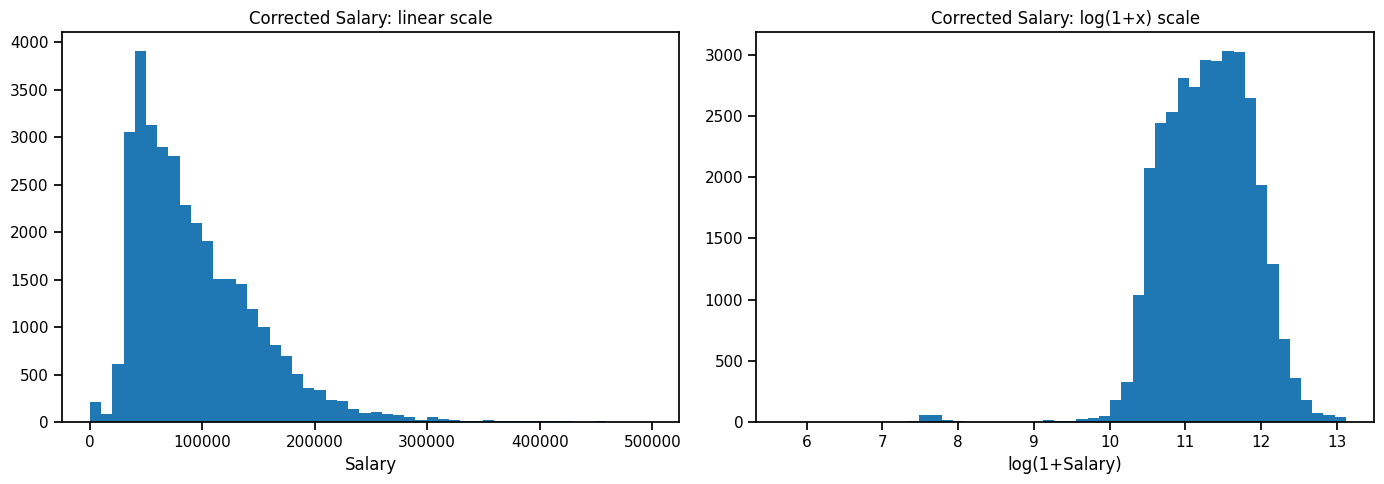

In [22]:
postings_filtered = postings[(postings['corrected_salary']>0) & (postings['corrected_salary']<500000)]
print('filtered sample size:', len(postings_filtered))

# Histogram of corrected salary (w/ log scale view)
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(postings_filtered['corrected_salary'].dropna(), bins=50)
ax[0].set_title('Corrected Salary: linear scale')
ax[0].set_xlabel('Salary')

ax[1].hist(np.log1p(postings_filtered['corrected_salary'].dropna()), bins=50)
ax[1].set_title('Corrected Salary: log(1+x) scale')
ax[1].set_xlabel('log(1+Salary)')
plt.tight_layout()
plt.show()

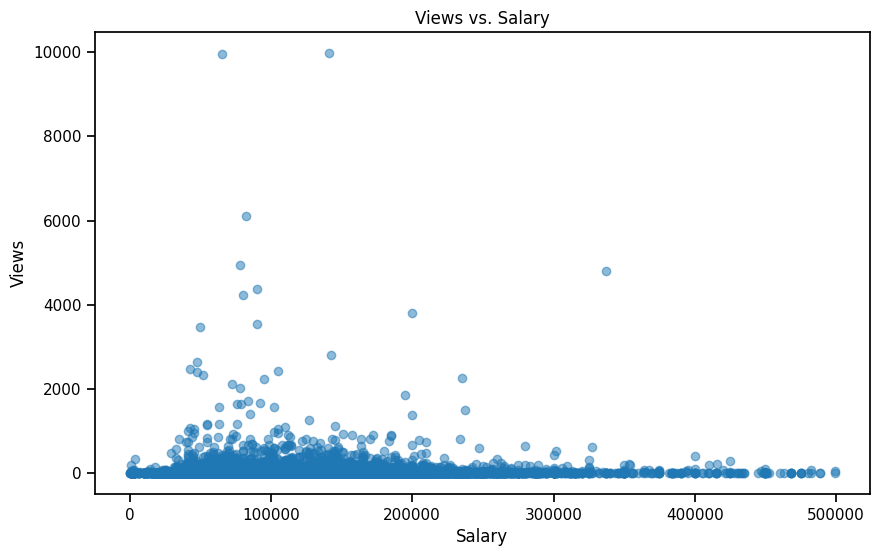

In [23]:
# Views vs. Salary
plt.scatter(postings_filtered['corrected_salary'], postings_filtered['views'], alpha=0.5)
plt.title('Views vs. Salary')
plt.xlabel('Salary')
plt.ylabel('Views')
plt.show()

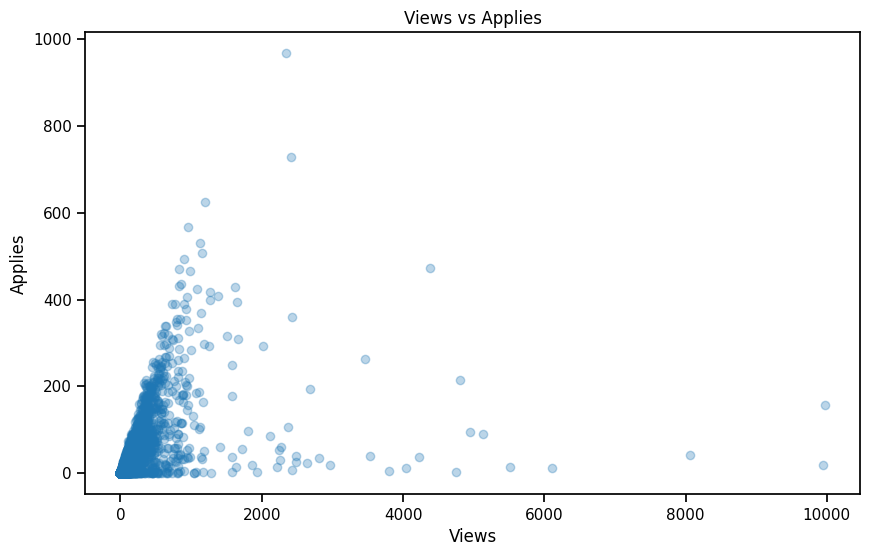

In [24]:
# Views vs. Applies
plt.scatter(postings['views'].fillna(0), postings['applies'].fillna(0), alpha=0.3)
plt.title('Views vs Applies')
plt.xlabel('Views')
plt.ylabel('Applies')
plt.show()

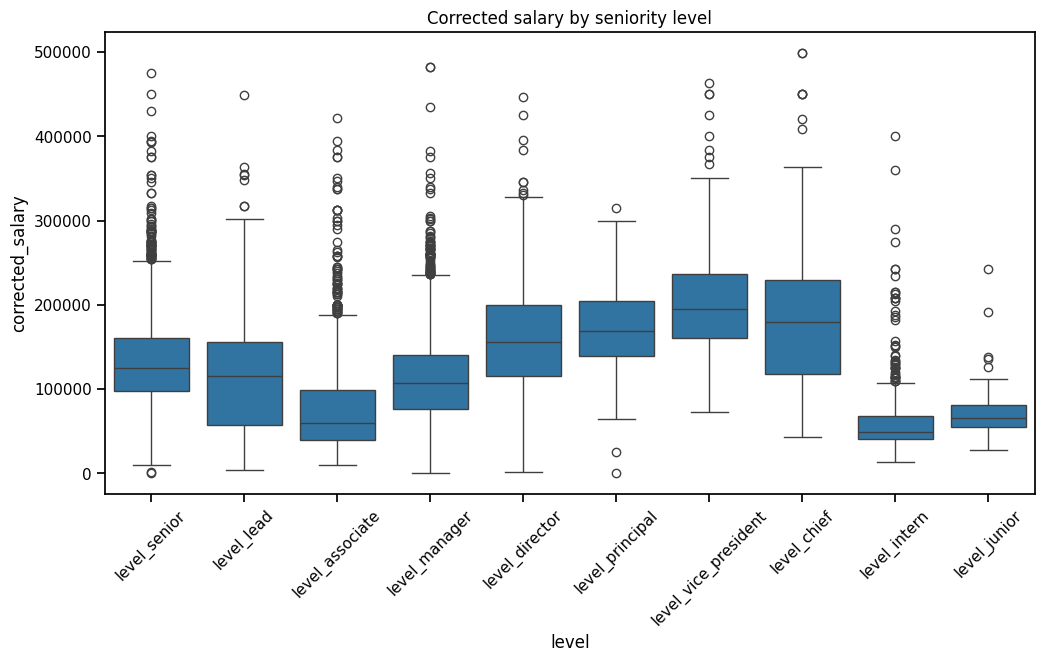

In [25]:
level_cols = [col for col in postings.columns if col.startswith('level_')]
df_levels = postings_filtered[['corrected_salary'] + level_cols].melt(id_vars=['corrected_salary'], var_name='level', value_name='is_level')
df_levels = df_levels[df_levels['is_level']]
plt.figure(figsize=(12,6))
sns.boxplot(x='level', y='corrected_salary', data=df_levels)
plt.title('Corrected salary by seniority level')
plt.xticks(rotation=45)
plt.show()

## Top categories: companies, states, work types

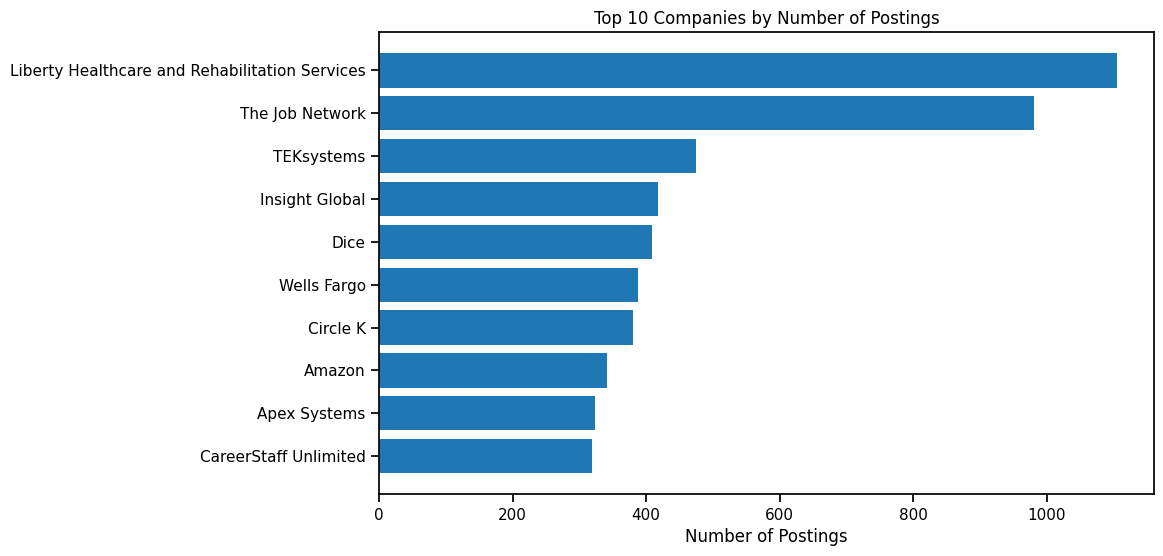

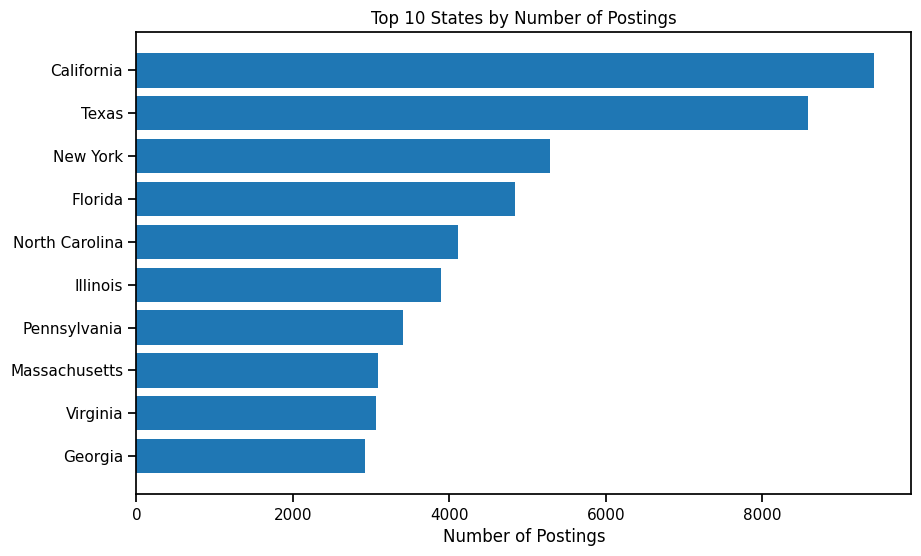

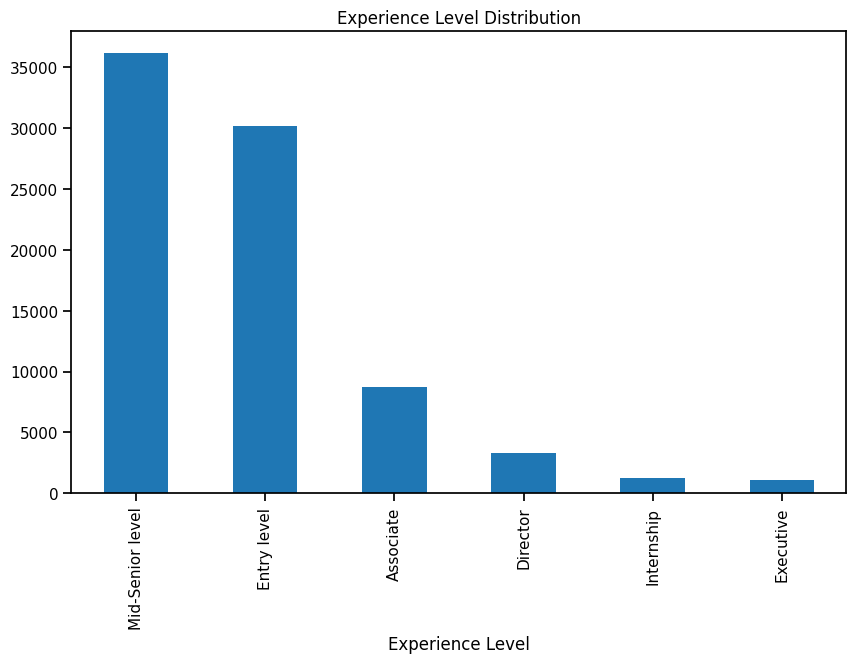

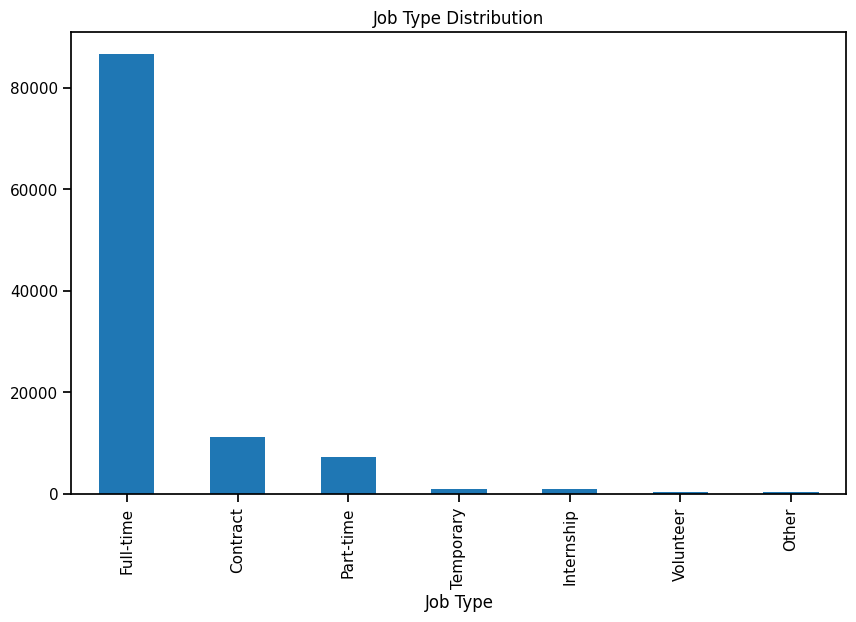

In [26]:
top_companies = postings['company_name'].value_counts().head(10)
plt.barh(top_companies.index[::-1], top_companies.values[::-1])
plt.title('Top 10 Companies by Number of Postings')
plt.xlabel('Number of Postings')
plt.show()

top_states = postings['state'].value_counts().head(10)
plt.barh(top_states.index[::-1], top_states.values[::-1])
plt.title('Top 10 States by Number of Postings')
plt.xlabel('Number of Postings')
plt.show()

postings['formatted_experience_level'].value_counts().plot(kind='bar')
plt.title('Experience Level Distribution')
plt.xlabel('Experience Level')
plt.show()

postings['formatted_work_type'].value_counts().plot(kind='bar')
plt.title('Job Type Distribution')
plt.xlabel('Job Type')
plt.show()

## Correlations (numeric columns)

Show a compact heatmap of correlations for numeric variables of interest.

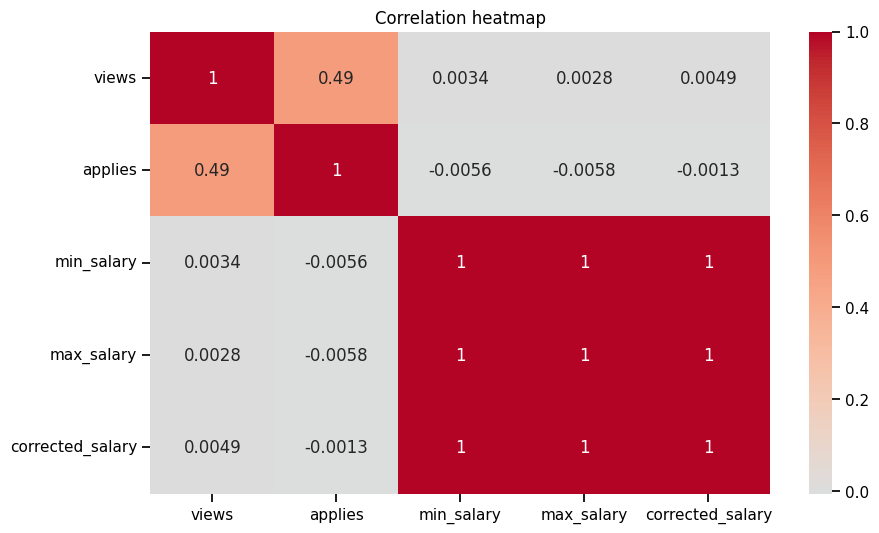

In [27]:
numeric_cols = ['views','applies','min_salary','max_salary','corrected_salary']
corr = postings[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation heatmap')
plt.show()

## Focus: Data Science job postings

Extract titles that look like data science roles and repeat key EDA steps specifically for that subset.

In [28]:
data_science_job_titles = []

for title in postings.title_normalized.unique():
    is_scientist = 'scien' in title
    
    ds_keywords = ['data', 'machine learning', 'ml', 'nlp', 'computer vision']
    is_data = any(k in title for k in ds_keywords)
    is_computer = 'computer' in title

    if is_scientist & is_data & (not is_computer):
        #print(title)
        data_science_job_titles.append(title)

data_science_postings = postings[postings.title_normalized.isin(data_science_job_titles)]
print('DS postings count:', len(data_science_postings))
display(data_science_postings[['title','title_normalized','company_name','corrected_salary']].head())

DS postings count: 262


,title,title_normalized,company_name,corrected_salary
366,Data Science Software Engineer,data science software engineer,Sovrinti,NaN
1338,Data Scientist Job,data scientist job,Armstrong World Industries,NaN
2887,NLP/data science/Data Analysis(Intern apr 30),nlp and data science and data analysis,Data Glacier,NaN
2951,Data Science intern ( Apr 30),data science intern,Data Glacier,NaN
3566,Senior Data Scientist 3 - Nonproliferation,senior data scientist 3,Pacific Northwest National Laboratory,177000.0


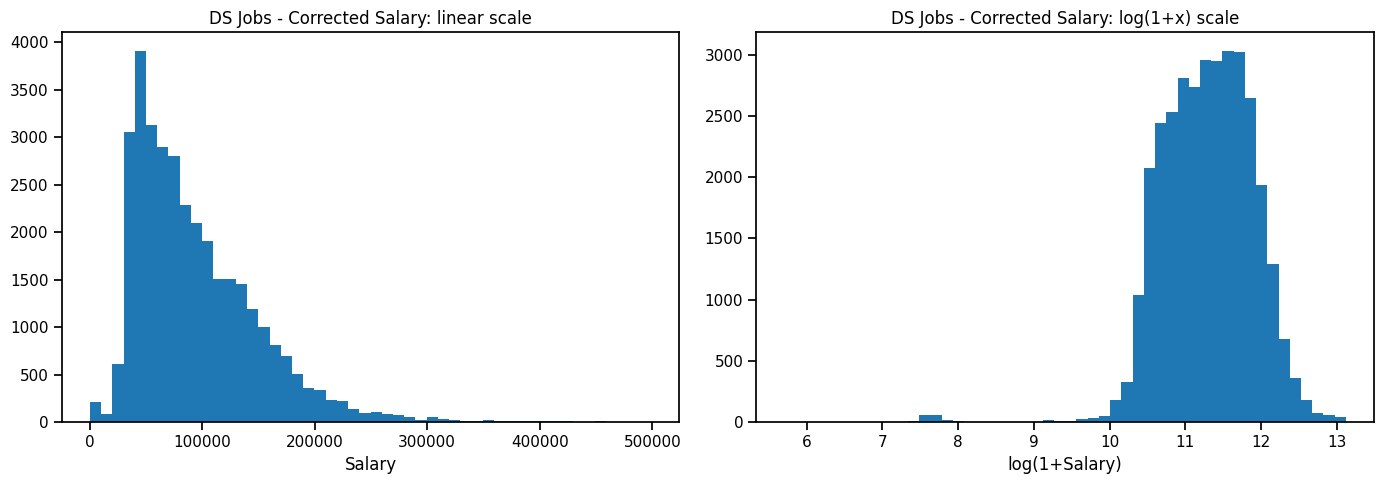

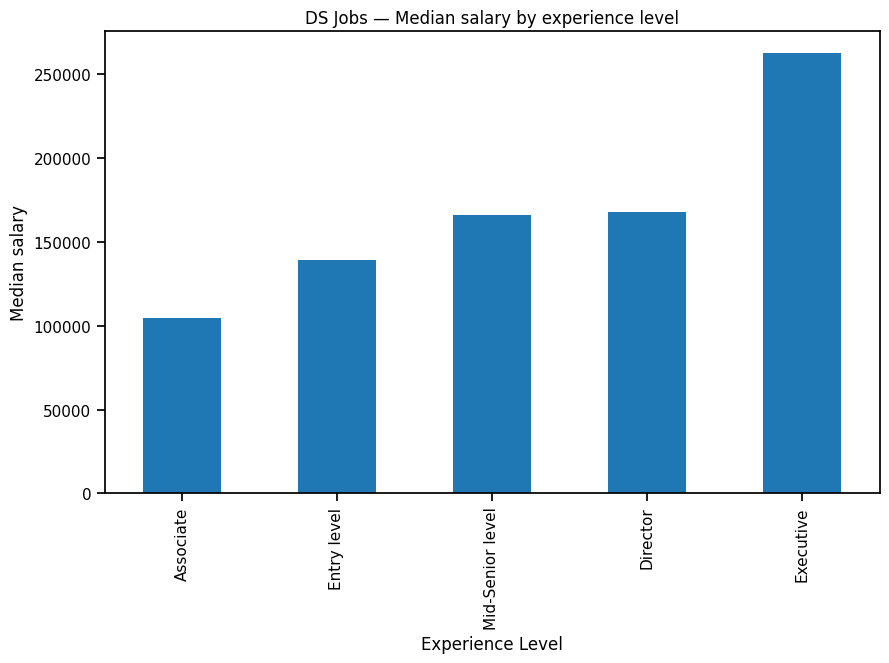

In [29]:
ds_filtered = data_science_postings[(data_science_postings['corrected_salary']>0) & (data_science_postings['corrected_salary']<500000)]

# Histogram of corrected salary (w/ log scale view)
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].hist(postings_filtered['corrected_salary'].dropna(), bins=50)
ax[0].set_title('DS Jobs - Corrected Salary: linear scale')
ax[0].set_xlabel('Salary')

ax[1].hist(np.log1p(postings_filtered['corrected_salary'].dropna()), bins=50)
ax[1].set_title('DS Jobs - Corrected Salary: log(1+x) scale')
ax[1].set_xlabel('log(1+Salary)')
plt.tight_layout()
plt.show()

# Salary by experience level
grouped = ds_filtered.groupby('formatted_experience_level')['corrected_salary'].median().sort_values()
grouped.plot(kind='bar')
plt.title('DS Jobs — Median salary by experience level')
plt.xlabel('Experience Level')
plt.ylabel('Median salary')
plt.show()

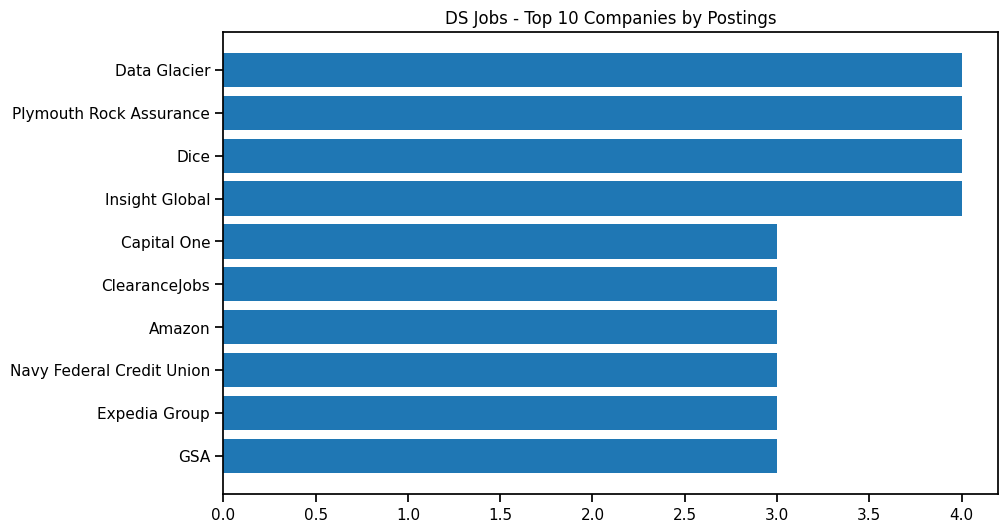

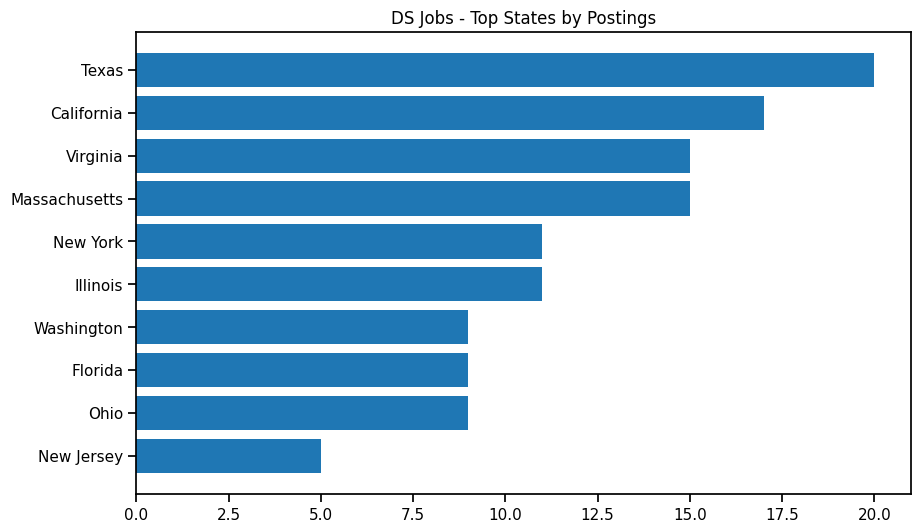

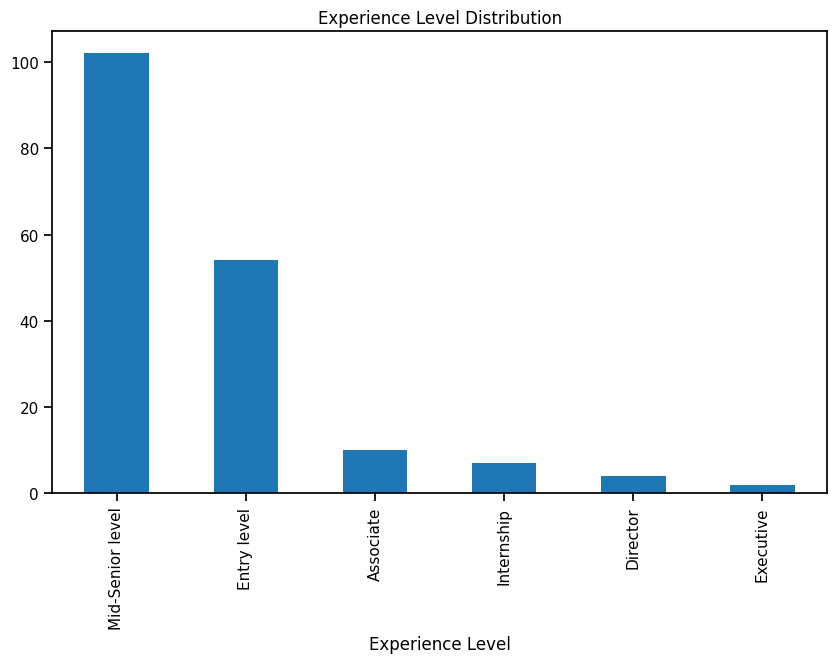

In [30]:
top_ds_co = data_science_postings['company_name'].value_counts().head(10)
plt.barh(top_ds_co.index[::-1], top_ds_co.values[::-1])
plt.title('DS Jobs - Top 10 Companies by Postings')
plt.show()

top_states_ds = data_science_postings['state'].value_counts().head(10)
plt.barh(top_states_ds.index[::-1], top_states_ds.values[::-1])
plt.title('DS Jobs - Top States by Postings')
plt.show()

data_science_postings['formatted_experience_level'].value_counts().plot(kind='bar')
plt.title('Experience Level Distribution')
plt.xlabel('Experience Level')
plt.show()